In [1]:
import fastai
from fastai import learner
from fastai import dataset
from fastai import model
from fastai.model import resnet34
from pathlib import Path
from fastai.text import *

import pandas as pd
import numpy as np
import spacy
import json
import re
import html

In [2]:
numbers = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

In [5]:
myData = pd.DataFrame()
def DataGenerator():
    numlist = ""
    starting_num = random.randint(0,9)
    for i in range(10):
        if i==0:
            numlist = str(numbers[(starting_num+i)%10])
        else:
            numlist = numlist + " " + str(numbers[(starting_num+i)%10])
    return numlist
DataGenerator()
for i in range(10000):
    myData = myData.append(pd.Series(DataGenerator()), ignore_index=True)
tok = Tokenizer()
texts = myData[0].astype(str)
#data = tok.proc_all_mp(partition_by_cores(texts.values.astype(str)))
data = tok.proc_all(texts.values.astype(str),'en')

In [6]:
freq = Counter(p for o in data for p in o)

In [7]:
itos = [o for o,c in freq.most_common(10) if c > 2]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [8]:
freq.most_common(10)

[('four', 10000),
 ('five', 10000),
 ('six', 10000),
 ('seven', 10000),
 ('eight', 10000),
 ('nine', 10000),
 ('zero', 10000),
 ('one', 10000),
 ('two', 10000),
 ('three', 10000)]

In [9]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(stoi)

12

In [10]:
tokenized_data = [[stoi[o] for o in i] for i in data]

In [11]:
tokenized_data[:10]

[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [7, 8, 9, 10, 11, 2, 3, 4, 5, 6],
 [11, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [4, 5, 6, 7, 8, 9, 10, 11, 2, 3],
 [6, 7, 8, 9, 10, 11, 2, 3, 4, 5],
 [5, 6, 7, 8, 9, 10, 11, 2, 3, 4],
 [11, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [5, 6, 7, 8, 9, 10, 11, 2, 3, 4],
 [8, 9, 10, 11, 2, 3, 4, 5, 6, 7],
 [3, 4, 5, 6, 7, 8, 9, 10, 11, 2]]

In [12]:
PATH = Path("data/counterExample/")

In [13]:
em_sz,nh,nl = 12,12,2
wd=1e-7
bptt=10
bs=8
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [14]:
combined_tokenized_data = np.concatenate(tokenized_data)

In [15]:
dataloader = LanguageModelLoader(combined_tokenized_data, bs, bptt)

In [16]:
modeldata = LanguageModelData(PATH,1,len(stoi), dataloader, dataloader)

In [17]:
learner = modeldata.get_model(opt_fn, em_sz, nh, nl)
learner.metrics = [accuracy]
learner.unfreeze()

In [18]:
learner.lr_find(1e-4, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      2.422673   2.20976    0.268638  



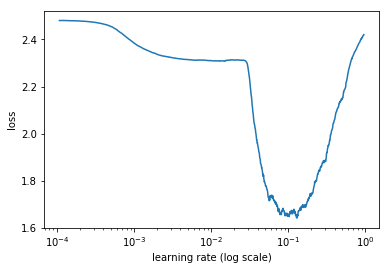

In [19]:
learner.sched.plot()

In [20]:
lr=2e-2

In [21]:
learner.fit(lr,4)

epoch      trn_loss   val_loss   accuracy                     
    0      1.248334   0.715402   0.903277  
    1      1.12616    0.592809   0.910194                     
    2      1.060565   0.57552    0.910173                     
    3      1.025335   0.56822    0.910169                     



[array([0.56822]), 0.9101687937422808]

In [26]:
learner.fit(lr/2,2)

epoch      trn_loss   val_loss   accuracy                      
    0      1.044155   0.559854   0.910135  
    1      0.973793   0.553958   0.910162                      



[array([0.55396]), 0.9101621260237339]

In [27]:
num = stoi["three"]
list_of_nums = []
for i in range(10):
    needPrediction = np.array([[num]])
    probs = learner.model(V(needPrediction))
    pred = to_np(probs[0][-1].exp()).argmax()
    list_of_nums += [itos[pred]]
    num = pred
print(list_of_nums)

['four', 'five', 'six', 'seven', 'eight', 'nine', 'zero', 'one', 'two', 'three']
